# Pairs-Trading Strategy Analysis

<a href="https://www.kaggle.com/code/addarm/pairs-trading-strategy-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![MidJourney Sea of Charts 2023.11.1](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/SeaOfChartBanner.png)

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

Pairs trading is a more advanced strategy that quants would use to trade a portfolio, rather than guessing on one instrument. In this article, we'll make an analysis of this market-neutral strategy that seeks to gain from the relative movements of two closely related financial instruments - using a simulation and free yahoo finance data.

This strategy is rooted in the **believe** that, in the long run, the two assets will maintain a consistent spread, making it possible to profit from their converging prices, irrespective of broader market trends as it focuses on the relationship between the selected assets.

This is a continuation of the [mean reversion](https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif/) article.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

Refer to the previous article for basics on [momentum and reversion techniques](https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif) and the utility functions used here.


In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_ts_df, plot_strategy

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


## Give Me More Data!

Collecting and sanitizing data for a pair trading strategy is crucial, we need to know who moves with who in a universe of financial insruments. 

Data collection is done through the trusty **yahoofinance**, but this time, we will pull in some crypto daily timeseries. 

Crypto tends to be volatile, and we might be pulling instruments that have already delisted or worse. This will make it hard to corellate prices with the more traditional stocks or indices and their dailies. We need to ensure data integrity by:
- Interpolate missing values.
- Smoothen outliers.
- Ensure all timeseries have the same number of data points. 

That last one will be challeging, as cryptobros trade all day, every day!  Let's do that:

In [29]:
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD',
                       'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG',
               'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'

universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes
universe_tickers_ts_map = {ticker: load_ticker_ts_df(
    ticker, START_DATE, END_DATE) for ticker in universe_tickers}


def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) -
                      pd.to_datetime(START_DATE)).days
    data_sanitized = {}

    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            # We cannot handle shorter TSs
            continue

        if len(data) > TS_DAYS_LENGTH:
            # Normalize to have the same length (TS_DAYS_LENGTH)
            data = data[-TS_DAYS_LENGTH:]

        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)

        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(
            np.isinf(data['Adj Close']))

        data_sanitized[ticker] = data

    return data_sanitized


# Sample some
uts_sanitized = sanitize_data(universe_tickers_ts_map)
uts_sanitized['JPM'].shape, uts_sanitized['BTC-USD'].shape

((1034, 6), (1034, 6))

Note the `date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')` which will set the data timewindow we want.
Then its all `interpolate` and `fillna` to cover those NaNs or Nones. We try our best to interpolate linearly or if this fails, just backfill with the latest sane value.

We verify that all is as expected with an `assert` and check the shapes of 2 random instruments, which should have the same dimensions.

# Who Moves Who?

Late's take the latest crypto scandal with FTX as an example in this analysis. With the downfall of this exchange, would that mean that the market will have more confidence in Banks until the scandal is forgotten? 

We'll corelation and cointegration to find patterns.

## Correlation and Cointegration

Correlation quantifies the relationship between two variables using the Pearson correlation coefficient (r). It ranges from -1 to 1, where:
$$ r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}} $$
1. **$r$:** is the Pearson correlation coefficient. 1 means they move perfectly together, -1 is the opposite.
2. **$X_i \text{ and } Y_i$:** are data points of the two variables.
3. **$\bar{X} \text{ and } \bar{Y}$:** are the means of the respective variables.

Cointegration, on the other hand, goes beyond - it assesses whether two assets are bound together over time, meaning their price spreads tend to mean-revert, offering opportunities when they temporarily diverge from their historical relationship. 

This is evaluated using statistical tests, such as the **Augmented Dickey-Fuller (ADF)** test, which checks whether the spread between the two assets is stationary. If the spread is stationary, it **suggests** that the assets are cointegrated and have a long-term relationship.

$$ \text{ADF statistic} = \frac{\text{Coefficient estimate} - 1}{\text{Standard error of the estimate}} $$
* **$\text{ ADF statistic }$:** is the Augmented Dickey-Fuller test statistic indicating the stationarity of the spread if >0
* **$\text{ Coefficient estimate }$:** estimated coefficient of a linear regression equation representing the relationship between the changes in the asset prices and the lagged values of those changes.
* **$\text{ Standard error }$:** of the coefficient estimate.

Luckily **numpy** and the **stats** library abstract the above complexities.

## Finding Pairs

While find these by testing the cointegration relationship. Quants would do this to signal buy and sell orders when the spread between the assets strays from its historical mean, aiming to capture opportunities  when the spread reverts to its long-term equilibrium. That's why we need all that data.

The code below will test a universe of stocks and, that other stuff, to see if there is a hidden relationship.

It will test what's called a **Null Hypothesis (H0)**, which in statistics means we can **assume** no effect or relationship. 
In general, if the p_value is below 0.02, H0 is rejected, and the pair has something going.

In [30]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint


def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)

    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))

    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

    return pvalue_matrix, pairs


# This section can take up to 5mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

Although we can simulate algo-trading in code, as people we need to visualize these relationships.

The heatmap below will give us a map of who is paired with who - based on the p-value discovered.

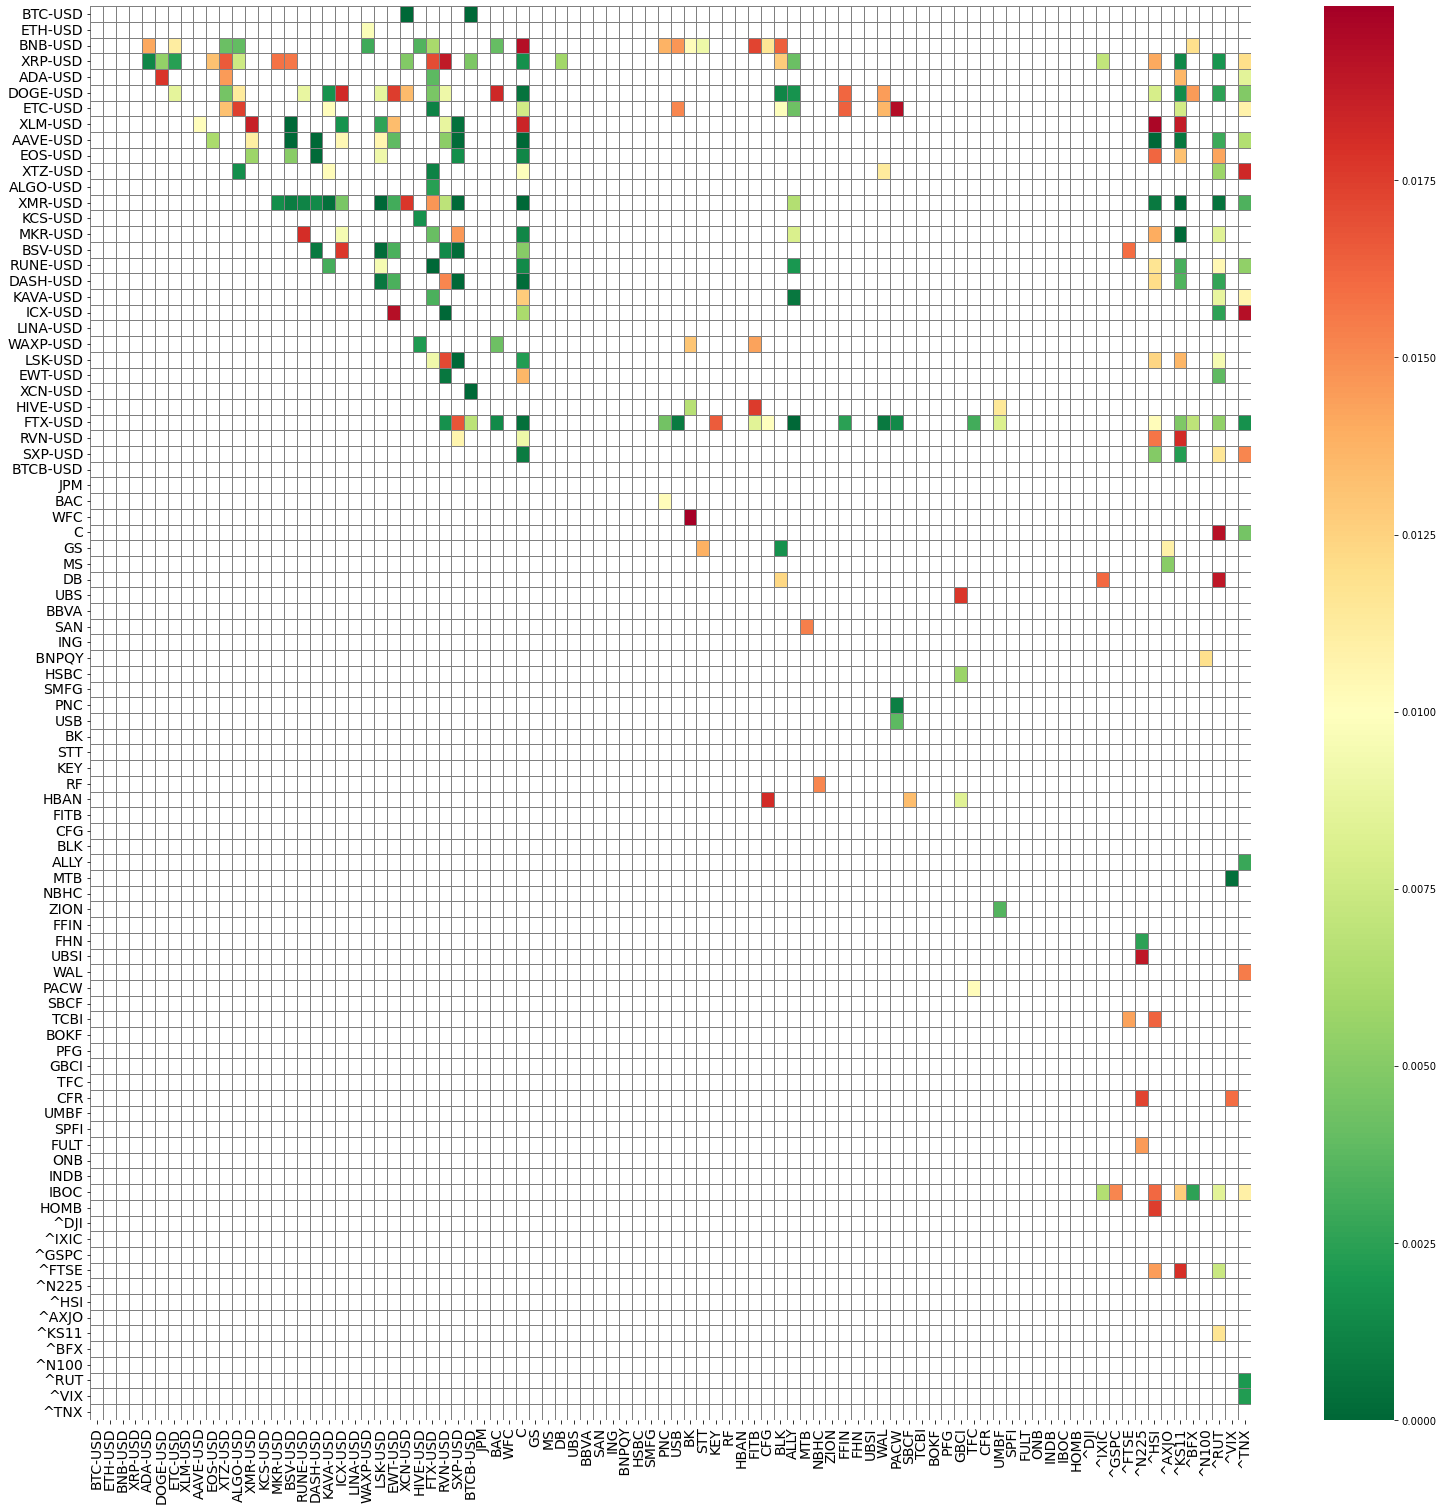

In [31]:
import seaborn as sns

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

That's quite a bunch - and all these crypto are in bed with each other!

Let's select 3 with the highest relationship. The barchart below helps us in identifying these pairs and their strength, the lesser the *p* value, the stronger:

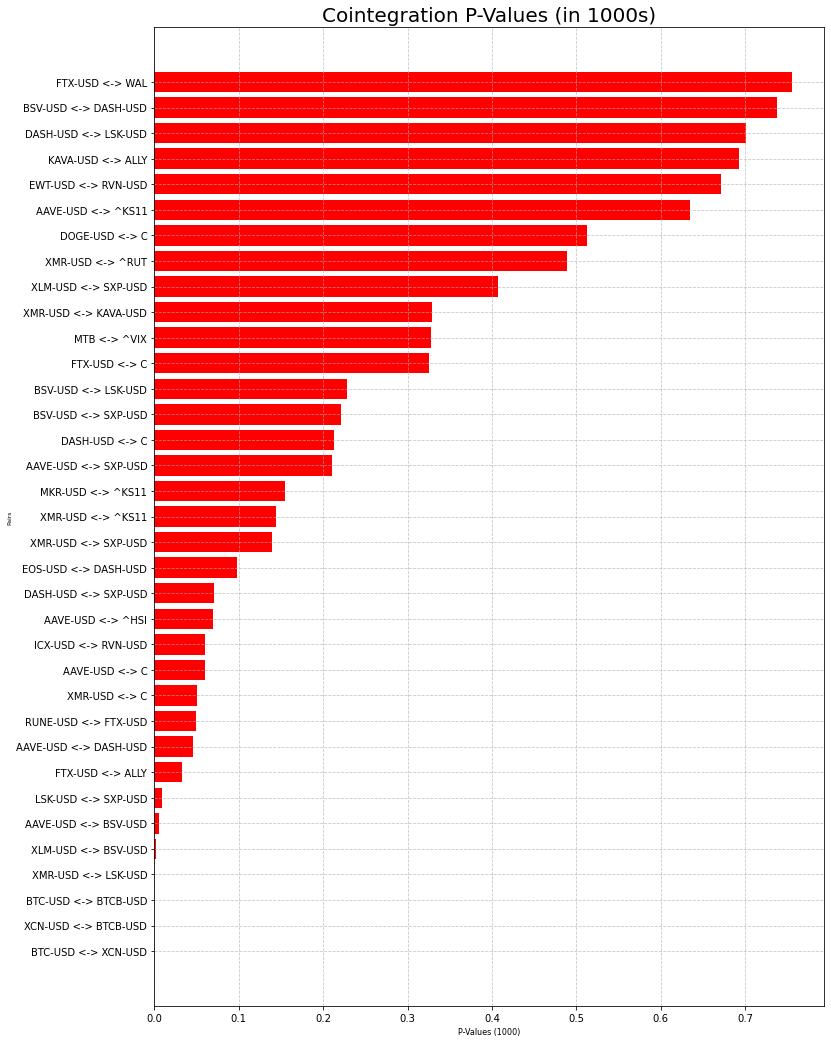

In [32]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

We have some sensible candidates:

- AAVE-USD with Citigroup Inc (C)
- XMR-UD with Citigroup Inc (C)
- FTX-USD (oh god!) with Ally Financial Inc (ALLY)

Let's have a look at their timeserieses with the code below. 
Given how mercurial and small these crypto instruments are, we choose to scale the prices to be bettere able to compare with the paired-stock. We will use **MinMax** from sktlearn, to tansform the closing prices. There is some smoothing with a **rolling window**, to allow us to see better the stationarity between the pairs:

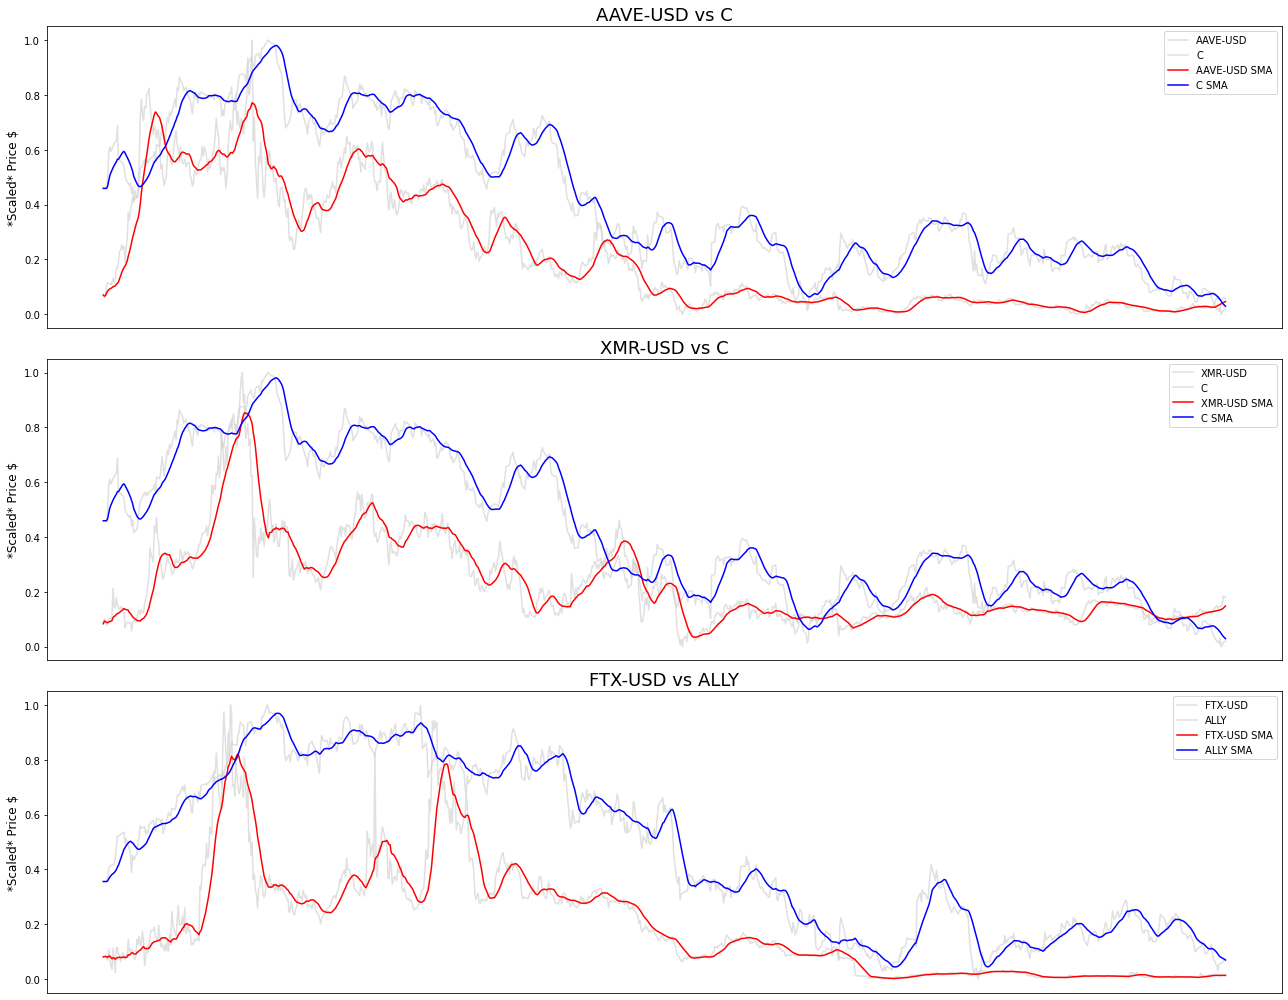

In [33]:
from sklearn.preprocessing import MinMaxScaler

ticker_pairs = [("AAVE-USD", "C"), ("XMR-USD", "C"), ("FTX-USD", "ALLY")]

fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_sanitized[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_sanitized[ticker2]['Adj Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

AAVE-USD and C look good for our experiment, as beyond the dislocation at the beginning of the series, the prices seem stationary in relation to each other.

We will create trading signals using the Z-score and mean. With a rolling window, so we don't have to split into training and tests sets. The Z-score is denoted as:
$$Z = \frac{X - \mu}{\sigma}$$
1. X is the price we want to standardize.
2. μ is the mean (average) of the rolling window.
3. σ is the standard deviation of the rolling window.

The Z-score measures how far the current ratio of the two asset prices is from its historical mean. 
When the Z-score surpasses a predefined threshold, typically +1 or -1, it generates a trading signal. If the Z-score goes above +1, it indicates that one asset is overvalued compared to the other, signaling a sell for the overvalued asset and a buy for the undervalued one. 

Conversely, if the Z-score drops below -1, it suggests the undervalued asset has become overvalued, prompting a sell for the former and a buy for the latter. This strategy leverages mean-reversion principles to capitalize on temporary divergences and the expectation of a return to the mean.

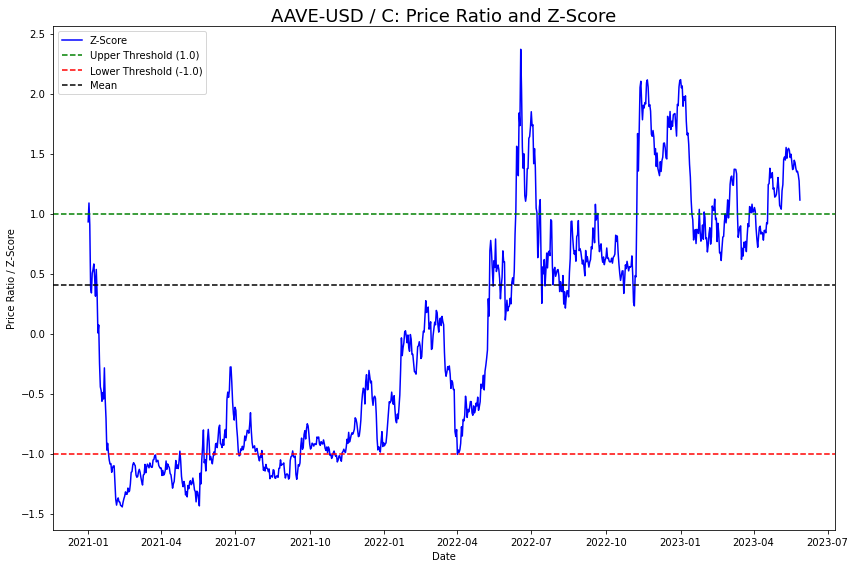

In [34]:
TRAIN = int(len(uts_sanitized["AAVE-USD"]) * 0.85)
TEST = len(uts_sanitized["AAVE-USD"]) - TRAIN

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["C"]["Adj Close"][:TRAIN]

# Calculate price ratio (AAVE-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))

ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std

ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')

# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(ratios_mean, color="black", linestyle='--', label="Mean")

ax.set_title('AAVE-USD / C: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

The green horizontal line here will signal a buy for Citi if crossed and a sell for Aave, the red line will do the opposite. This chart is only for visualizing the stationary, in running our signal, the thresholds will move with a rolling window to reflect the changes in the market.

Let's apply the signal:

c:\Users\worker\workspace\quant_research\analysis_utils.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)
c:\Users\worker\workspace\quant_research\analysis_utils.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


<Figure size 1872x1296 with 0 Axes>

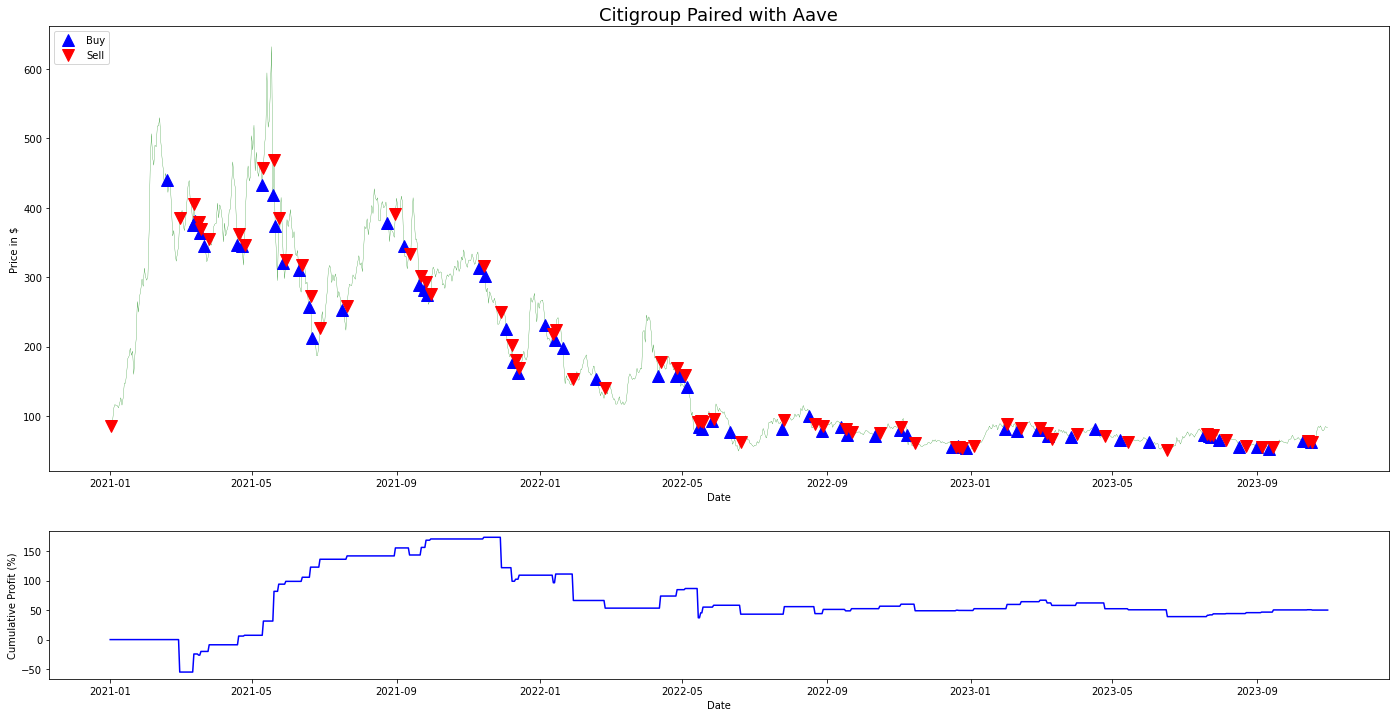

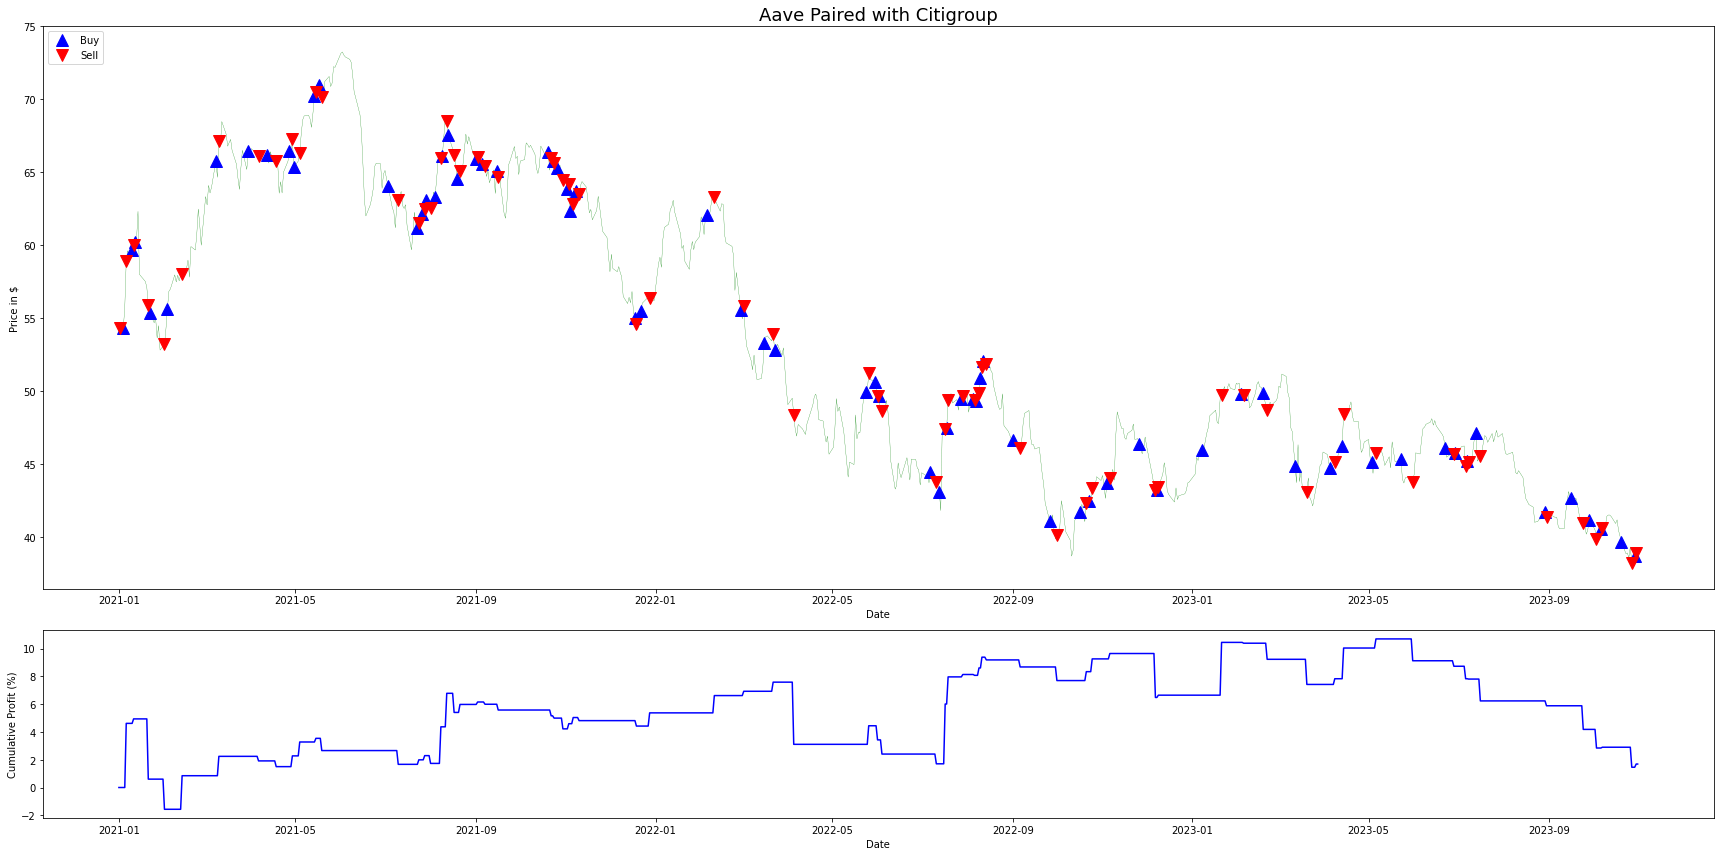

In [35]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.

    """
    ratios = ticker1_ts / ticker2_ts

    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()

    z_scores = (ratios - ratios_mean) / ratios_std

    buy = ratios.copy()
    sell = ratios.copy()

    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df


AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"]
C_ts = uts_sanitized["C"]["Adj Close"]

plt.figure(figsize=(26, 18))
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)

signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)

ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'Citigroup Paired with Aave', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'Aave Paired with Citigroup', fontsize=18)
plt.tight_layout()
plt.show()

In an algotrading system these would be running together, therefore the returns are best represented as a sum.

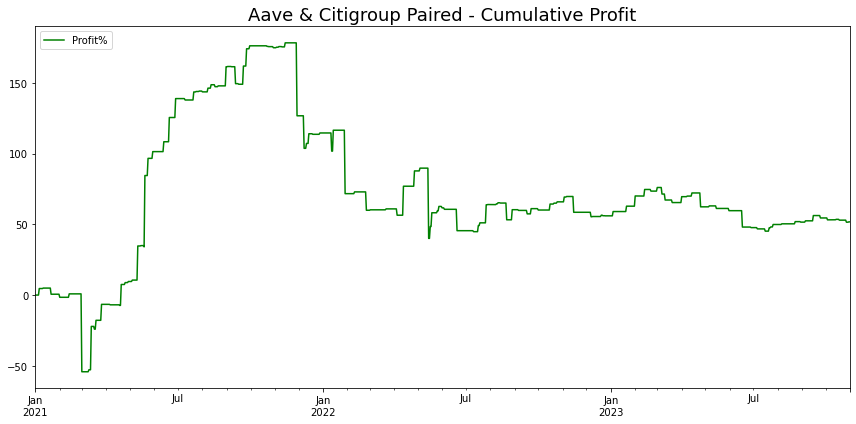

In [36]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'Aave & Citigroup Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()

That's surprisingly good, minus that 50% drawdown, this strategy returned a paper-returns of 100% (vs SnP500's 2 year 10%). 

Then again it came with high variance due to whatever crypto instrument we paired Citi with, this is were quants would measure the strategy with risk-adjusted performance indicators like the **Sortino Ratio**.

# Conclusion

To end this article, we learned about pairs-trading strategy, and saw that it had these attributes:

- **Market-Neutral**: Pair trading strategies aim to be market-neutral, meaning they seek to profit from relative price movements between two assets rather than overall market direction.
- **Statistical Basis**: The strategy relies on statistical measures like the Z-score and cointegration, providing a quantitative foundation for decision-making.
- Mean Reversion: It takes advantage of mean reversion, exploiting the tendency of asset prices to revert to their historical averages. Check out the previous article.

Though in reality, it would have these challenges:

- **Transaction Cost**s: We signaled a lot of trades in our simulation, that would create severe commission and exexution costs.
- **Risk of Non-Stationarity**: If asset correlations or cointegration break down, the strategy will underperform and create risk.

While doing quantitative analysis and coding for financial engineering is challenging, making youtube trading courses are not, always be sceptical!

![Shovels](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/shovels.png)

## References

- https://numpy.org/doc/stable/reference/
- https://www.investopedia.com/terms/p/pairstrade.asp 
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html 
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://www.statisticshowto.com/cointegration/
- https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif 

## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/pair-trading-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/addarm/pairs-trading-strategy-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.